In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from matplotlib.patches import Polygon
import glob
import os as os

In [ ]:
basepath = r"..."

# colors
lakecolor = '#ca3e3dff' 
marinecolor = '#46556aff'
background = '#f8f6f4ff'#f7f5efff, # f3f1efff
shading = '#e7e5e3ff'
darkred = '#9c2626ff'
olive = '#677834ff'
lightolive = '#9da737ff'
darkolive = '#364621ff'

def read_MT_margins(path):
    MT = pd.read_csv(path, 
                      skiprows=2,
                      names = ["year", "month", "day", "serial_date", "pos_flowline", "pos_rel", "change","change_rate", "terminus_width", "path_length", "node_distance", "box_width", "box_area"]
                      )

    MT['date'] = MT['year'].astype(str) + '-' + MT['month'].astype(str) + '-' + MT['day'].astype(str)
    MT.index = pd.to_datetime(MT['date'])
    MT.sort_index(inplace = True)
    MT['pos_rel_inv'] = (((MT['pos_rel'] - MT['pos_rel'].iloc[3])*(-1))/1000)

    return MT

In [ ]:
# reading MT margins
MT = read_MT_margins(basepath + r"...\3.1_glacier_margins_and_flowline\MT_margins.csv")

# Group by year and find the index of the minimum and maximum values in the 'pos_flowline' column
min_indices = MT.groupby('year')['pos_flowline'].idxmin()
max_indices = MT.groupby('year')['pos_flowline'].idxmax()
min_max_diff = MT.groupby('year')['pos_flowline'].max() - MT.groupby('year')['pos_flowline'].min()

# reading runoff data
runoff = pd.read_csv(basepath + r"...\3.8_racmo_oras5\runoff_whole_catchment.csv", usecols=["time", 'runoffcorr'], index_col='time', parse_dates=True)

# reading and processing LT velocities
MT_raw = pd.read_csv(basepath + r"...\3.3_ice_surface_velocities\MT_ticoi_itslive_dataf.csv")
MT_inv = pd.read_csv(basepath + r"...\3.3_ice_surface_velocities\MT_ticoi_itslive_dataf_lp.csv")
MT_rawE = MT_raw[MT_raw['label'] == 'E'].copy()
MT_invE = MT_inv[MT_inv['label'] == 'E'].copy()

MT_rawQ = MT_raw[MT_raw['label'] == 'P'].copy()
MT_invQ = MT_inv[MT_inv['label'] == 'P'].copy()

MT_rawE['date_cori'] = pd.to_datetime(MT_rawE['date_cori'])
MT_invE['date_cori'] = pd.to_datetime(MT_invE['date_cori'])
MT_rawE['offset_bar'] = pd.to_timedelta(MT_rawE['offset_bar'])
MT_invE['offset_bar'] = pd.to_timedelta(MT_invE['offset_bar'])

MT_rawQ['date_cori'] = pd.to_datetime(MT_rawQ['date_cori'])
MT_invQ['date_cori'] = pd.to_datetime(MT_invQ['date_cori'])
MT_rawQ['offset_bar'] = pd.to_timedelta(MT_rawQ['offset_bar'])
MT_invQ['offset_bar'] = pd.to_timedelta(MT_invQ['offset_bar'])

UP_raw = pd.read_csv(basepath + r"...\3.3_ice_surface_velocities\UP_ticoi_itslive_dataf.csv")
UP_inv = pd.read_csv(basepath + r"...\3.3_ice_surface_velocities\UP_ticoi_itslive_dataf_lp.csv")
UP_raw['date_cori'] = pd.to_datetime(UP_raw['date_cori'])
UP_inv['date_cori'] = pd.to_datetime(UP_inv['date_cori'])

MTfront_raw = pd.read_csv(basepath + r"...\3.3_ice_surface_velocities\MTfront_ticoi_itslive_dataf.csv")
MTfront_inv = pd.read_csv(basepath + r"...\3.3_ice_surface_velocities\MTfront_ticoi_itslive_dataf_lp.csv")
MTfront_raw['date_cori'] = pd.to_datetime(MTfront_raw['date_cori'])
MTfront_inv['date_cori'] = pd.to_datetime(MTfront_inv['date_cori'])

In [ ]:
# print a STATISTICS SUMMARY
# ============================================

print("=" * 60)
print("STATISTICS SUMMARY")
print("=" * 60)

# --- Runoff Periods ---
print("\n1. RUNOFF PERIODS (threshold = 2 mm/day)")
print("-" * 60)
threshold = 2
runoff_periods = []

for year, group in runoff.groupby(runoff.index.year):
    above_threshold = group[group['runoffcorr'] >= threshold]
    if not above_threshold.empty:
        start_date = above_threshold.index.min()
        end_date = above_threshold.index.max()
        runoff_periods.append({'year': year, 'start_date': start_date, 'end_date': end_date})

runoff_periods_df = pd.DataFrame(runoff_periods)
#print(runoff_periods_df.to_string(index=False))

# --- Ice Velocity Statistics ---
# Define winter and summer months
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Add month columns
MT_invE['month'] = MT_invE['date_cori'].dt.month
UP_inv['month'] = UP_inv['date_cori'].dt.month

print("\n2. MT POINT (E) - ICE VELOCITY STATISTICS")
print("-" * 60)
print(f"Min velocity: {MT_invE['vv'].min():.2f} m/year")
print(f"Max velocity: {MT_invE['vv'].max():.2f} m/year")

# Yearly averages
yearly_avg_vv_MT = MT_invE.dropna(subset=['vv']).groupby(MT_invE['date_cori'].dt.year)['vv'].mean()
print(f"\nYearly averages:")
print(yearly_avg_vv_MT.to_string())

# Monthly averages across all years
monthly_avg_vv_overall_MT = MT_invE.dropna(subset=['vv']).groupby(MT_invE['date_cori'].dt.month)['vv'].mean()
monthly_avg_vv_overall_MT.index = monthly_avg_vv_overall_MT.index.map(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))
print(f"\nMonthly averages (across all years):")
print(monthly_avg_vv_overall_MT.to_string())

# Seasonal comparison
winter_avg_MT = MT_invE[MT_invE['month'].isin(winter_months)]['vv'].mean()
summer_avg_MT = MT_invE[MT_invE['month'].isin(summer_months)]['vv'].mean()
percent_change_MT = ((summer_avg_MT - winter_avg_MT) / winter_avg_MT) * 100
print(f"\nSeasonal comparison:")
print(f"  Winter (Dec-Jan-Feb) avg: {winter_avg_MT:.2f} m/year")
print(f"  Summer (Jun-Jul-Aug) avg: {summer_avg_MT:.2f} m/year")
print(f"  Percent change (summer vs winter): {percent_change_MT:.2f}%")

print("\n3. UP POINT (Q) - ICE VELOCITY STATISTICS")
print("-" * 60)
print(f"Min velocity: {UP_inv['vv'].min():.2f} m/year")
print(f"Max velocity: {UP_inv['vv'].max():.2f} m/year")

# Yearly averages
yearly_avg_vv_UP = UP_inv.dropna(subset=['vv']).groupby(UP_inv['date_cori'].dt.year)['vv'].mean()
print(f"\nYearly averages:")
print(yearly_avg_vv_UP.to_string())

# Monthly averages across all years
monthly_avg_vv_overall_UP = UP_inv.dropna(subset=['vv']).groupby(UP_inv['date_cori'].dt.month)['vv'].mean()
monthly_avg_vv_overall_UP.index = monthly_avg_vv_overall_UP.index.map(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))
print(f"\nMonthly averages (across all years):")
print(monthly_avg_vv_overall_UP.to_string())

# Seasonal comparison
winter_avg_UP = UP_inv[UP_inv['month'].isin(winter_months)]['vv'].mean()
summer_avg_UP = UP_inv[UP_inv['month'].isin(summer_months)]['vv'].mean()
percent_change_UP = ((summer_avg_UP - winter_avg_UP) / winter_avg_UP) * 100
print(f"\nSeasonal comparison:")
print(f"  Winter (Dec-Jan-Feb) avg: {winter_avg_UP:.2f} m/year")
print(f"  Summer (Jun-Jul-Aug) avg: {summer_avg_UP:.2f} m/year")
print(f"  Percent change (summer vs winter): {percent_change_UP:.2f}%")

print("\n" + "=" * 60)
print("END OF STATISTICS SUMMARY")
print("=" * 60)

STATISTICS SUMMARY

1. RUNOFF PERIODS (threshold = 2 mm/day)
------------------------------------------------------------

2. MT POINT (E) - ICE VELOCITY STATISTICS
------------------------------------------------------------
Min velocity: 1481.53 m/year
Max velocity: 2094.24 m/year

Yearly averages:
date_cori
2016    1736.675588
2017    1843.936438
2018    1749.153014
2019    1880.258493
2020    1954.772329
2021    1891.272329
2022    1739.910548
2023    1617.721096
2024    1540.240580

Monthly averages (across all years):
date_cori
Jan    1804.503774
Feb    1757.078800
Mar    1723.986364
Apr    1690.074815
May    1734.330000
Jun    1748.426852
Jul    1758.961897
Aug    1776.670185
Sep    1798.297037
Oct    1830.200556
Nov    1839.739444
Dec    1839.328200

Seasonal comparison:
  Winter (Dec-Jan-Feb) avg: 1800.39 m/year
  Summer (Jun-Jul-Aug) avg: 1761.30 m/year
  Percent change (summer vs winter): -2.17%

3. UP POINT (Q) - ICE VELOCITY STATISTICS
-------------------------------------

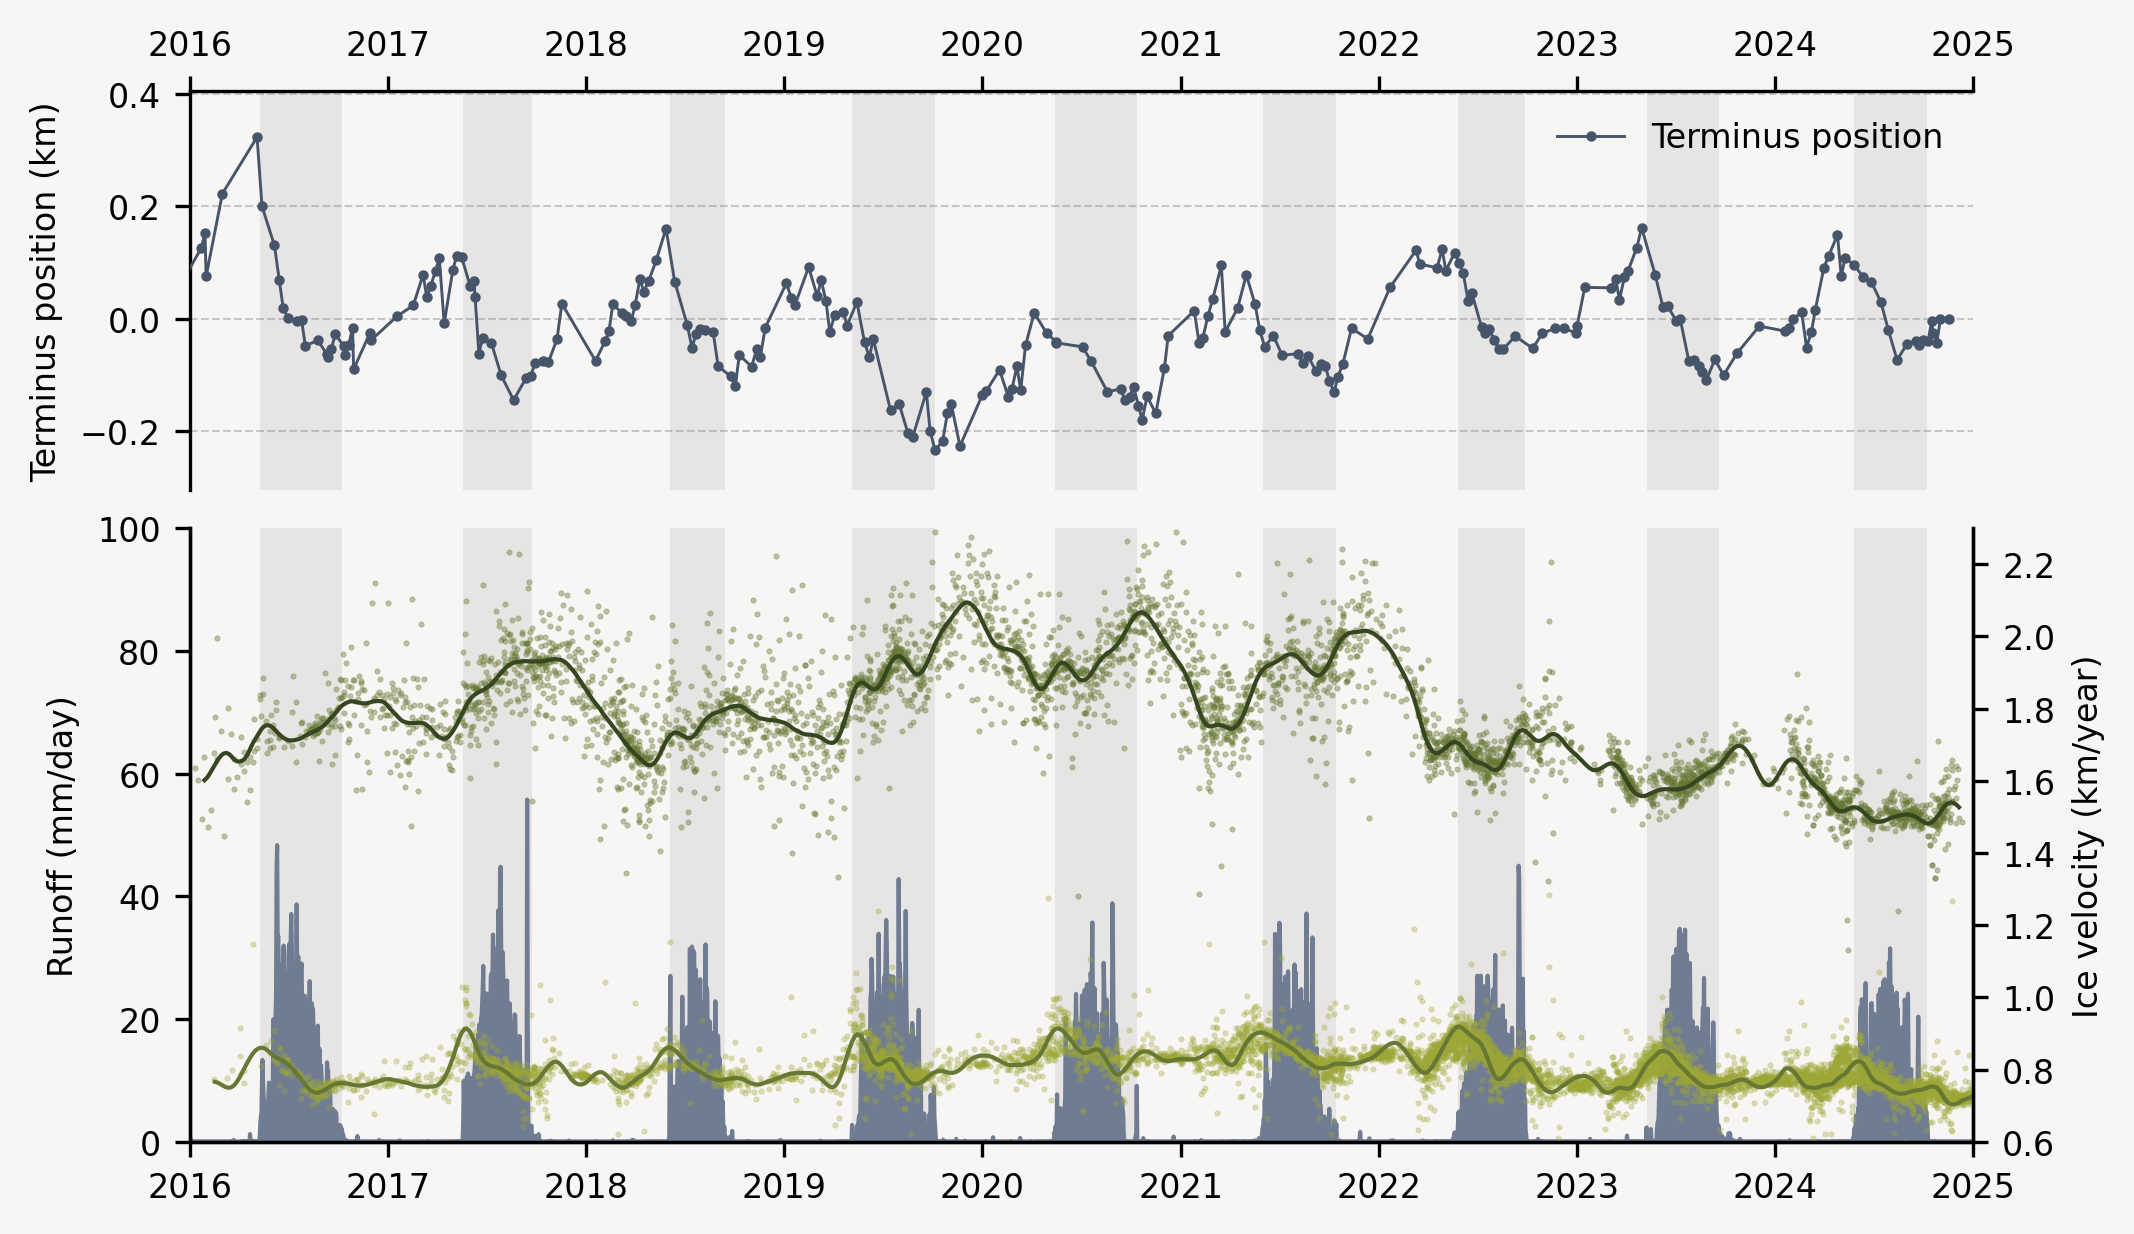

In [15]:
# Create figure and axes
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 4), dpi=300, 
                               gridspec_kw={'height_ratios': [1.3, 2]}, 
                               facecolor=background, layout="constrained")

# Set background colors
ax.set_facecolor(background)
ax2.set_facecolor(background)

# Plot terminus position
ax.plot(MT.index, MT.pos_rel/1000, marker='o', markersize=1.5, linewidth=0.7, 
        color=marinecolor, label='Terminus position', zorder=5)

# Plot runoff
ax2.fill_between(runoff.index, 0, runoff.runoffcorr, color=lightmarine, 
                 zorder=1, label="Runoff (RACMO2.3p2)")

# Create twin axis for velocity
ax3 = ax2.twinx()

# Plot velocity data
ax3.scatter(MT_rawE['date_cori'], MT_rawE['vv']/1000, marker='o', s=0.2, 
            color=olive, alpha=0.5, label='Observations with time span')
ax3.plot(MT_invE['date_cori'], MT_invE['vv']/1000, color=darkolive, 
         linewidth=1, label='Inverted velocity')
ax3.scatter(UP_raw['date_cori'], UP_raw['vv']/1000, marker='o', s=0.2, 
            color=lightolive, alpha=0.4, label='Observations with time span (Q)')
ax3.plot(UP_inv['date_cori'], UP_inv['vv']/1000, color=olive, 
         linewidth=1, label='Inverted velocity (Q)')

# Set axis limits
ax.set_xlim(date(2016, 1, 1), date(2025, 1, 1))
ax2.set_xlim(date(2016, 1, 1), date(2025, 1, 1))
ax.set_ylim(-0.305, 0.405)
ax2.set_ylim(0, 100)
ax3.set_ylim(0.6, 2.3)

# Configure spines
ax.spines[['bottom', 'right']].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Configure ticks
ax.tick_params(right=False, labelright=False, labelbottom=False, bottom=False,
               top=True, labeltop=True, labelsize=8)
ax2.tick_params(right=False, labelright=False, labelbottom=True, bottom=True,
                top=False, labeltop=False, labelsize=8)
ax3.tick_params(right=True, labelright=True, labelbottom=True, bottom=True,
                top=False, labeltop=False, labelsize=8, labelleft=False, left=False)

# Add shading for runoff periods
for _, row in runoff_periods_df.iterrows():
    ax.axvspan(row['start_date'], row['end_date'], facecolor=shading, 
               alpha=1, edgecolor='none', zorder=0)
    ax2.axvspan(row['start_date'], row['end_date'], facecolor=shading, 
                alpha=1, edgecolor='none', zorder=0)

# Add labels
ax.set_ylabel('Terminus position (km)', fontsize=8)
ax2.set_ylabel('Runoff (mm/day)', fontsize=8)
ax3.set_ylabel('Ice velocity (km/year)', fontsize=8)

# Add legends and grid
ax.legend(loc='upper right', fontsize=8, frameon=False)
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.show()
